In [16]:
%load_ext autoreload
%autoreload 2
%run nnn/ipynb_init.py
%matplotlib inline
import nupack

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data prep

## Basic filtering

This removes non-hairpin forming control constructs to make model training easier.

### arr_v0

No 2 state filter. Not really used but kept to be consistent with historical analysis.

86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
64.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
Load from file ./data/fitted_variant/NNNlib2b_DNA_20211022_v6.CPvariant.gz
86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
Load from file ./data/fitted_variant/NNNlib2b_DNA_20211216_v9.CPvariant.gz
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5

Combining dH

Combining Tm

Combining dG_37

Combining dS

Combining fmax

Combining fmin
(30680, 42)


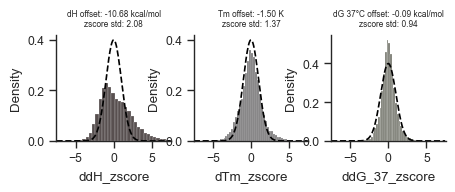

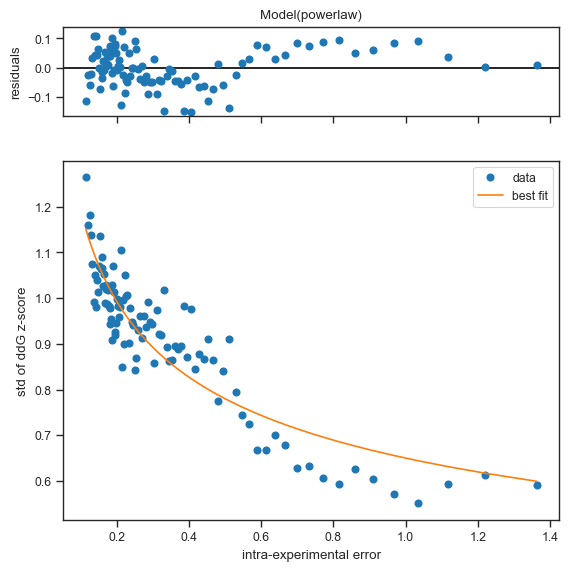

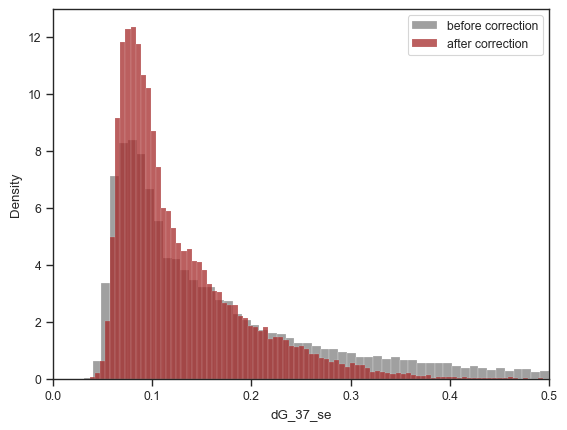

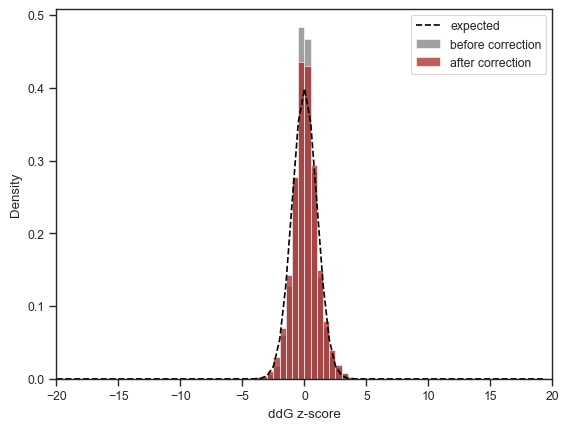

In [50]:
annotation_file = './data/annotation/NNNlib2b_annotation_20220519.tsv'
annotation = fileio.read_annotation(annotation_file)
replicate_df = pd.read_table('./data/nnnlib2b_replicates.tsv')
arraydata = ArrayData(replicate_df=replicate_df.iloc[:3,:],
                      annotation_file=annotation_file,
                      learn_error_adjust_from=('r1', 'r2'))
arr = arraydata.data.join(arraydata.annotation)

excluded_construct_type = ['pseudoknot_pt_muts', 'PolyNTControls', 'RepeatControls', 'StemDangle_3p', 'StemDangle_53p', 'StemDangle_5p', 'PUMcontrols']
arr = arr[arr.reset_index().ConstructType.apply(lambda s: s not in excluded_construct_type).values]
arr = arr.dropna(subset=['ConstructType', 'RefSeq','TargetStruct'])

print(arr.shape)
arr.to_csv(os.path.join('./data/models/raw', 'arr_v0_n=%d.csv' % arr.shape[0]))

### arr_v1

With (relaxed) 2-state filter & variant-level Tm filter.

86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
64.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
71.46% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
64.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
71.46% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5


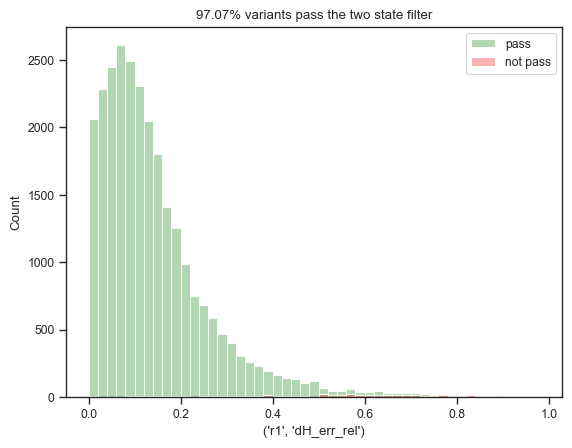

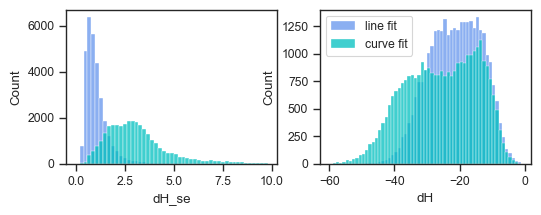

(27732, 45)


In [169]:
annotation_file = './data/annotation/NNNlib2b_annotation_20220519.tsv'
annotation = fileio.read_annotation(annotation_file, sodium=0.083)
replicate_df = pd.read_table('./data/nnnlib2b_replicates.tsv')

arraydata = ArrayData(replicate_df=replicate_df.iloc[:4,:],
                    annotation_file=annotation_file)

myfilter = "dH_err_rel < 0.5 & Tm_err_abs < 10 & redchi < 2 & n_inlier > 8"
pass_df = arraydata.filter_two_state(min_rep_pass=1, force_recalculate=True, overwrite_dH=False, 
                                     inplace=True, myfilter=myfilter)

variant_filter = 'Tm < 60 & Tm > 0'
arr = arraydata.data.join(arraydata.annotation).query(variant_filter)

excluded_construct_type = ['pseudoknot_pt_muts', 'PolyNTControls', 'RepeatControls', 'StemDangle_3p', 'StemDangle_53p', 'StemDangle_5p', 'PUMcontrols']
arr = arr[arr.reset_index().ConstructType.apply(lambda s: s not in excluded_construct_type).values]
arr = arr.dropna(subset=['ConstructType', 'RefSeq','TargetStruct'])

print(arr.shape)
arr.to_csv(os.path.join('./data/models/raw', 'arr_v1_n=%d.csv' % arr.shape[0]))

## Basic preprocessing

### Adjust offset

In [180]:
arr = pd.read_csv('./data/models/raw/arr_v1_n=27732.csv', index_col=0)

(-4.0, 0.0)

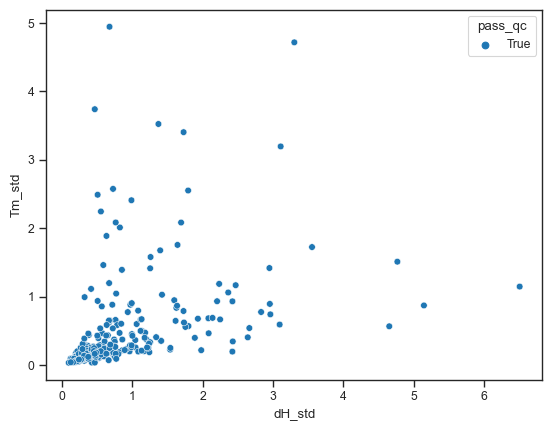

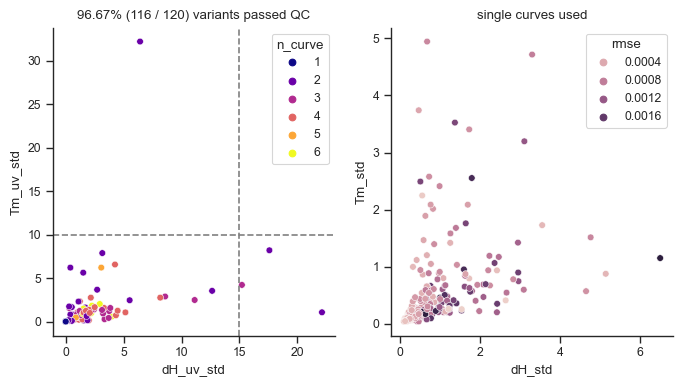

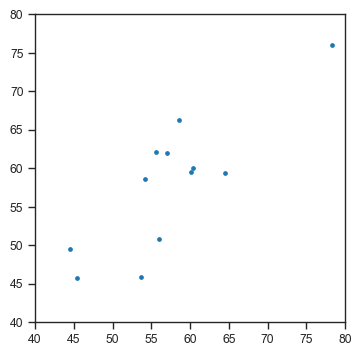

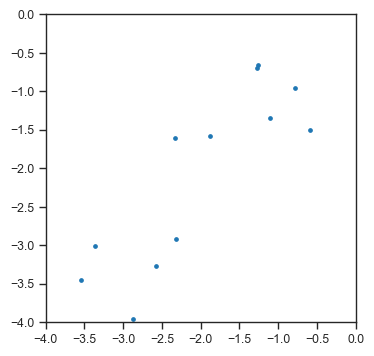

In [44]:
"""
Get the offset the violent way
"""
# copy pasted from command center for convenience
# only one peak found by AnalyzePeaks
hplc_clean_seqid = ["WC68_stem_3p", "WC68_stem_5p", "WC1025_split_5p", \
"WC1025_split_3p", "WC1375_stem_5p", "WC1375_stem_3p", "DMM004_5p", \
"DMM004_3p", "DMM005_5p", "DMM005_3p", "DMM006_5p", "DMM007_5p", \
"DMM007_3p", "BC0", "BC1", "BC6", "BC7", "BC8", "BC9", "BC10", \
"BC11", "MMCNNN2328", "MMCNNN2331", "MMCNNN2334", "MMCNNN2335", \
"MMCNNN2336", "MMCNNN2337", "MMTM1325", "MMTM176", "MMTM178", \
"MMTM179", "MMTM181", "MMTM185", "MMTM189", "MMTM1917", "MMTM29", \
"MMTM397", "MMTM509", "MMTM877", "DMM003_3p_rc", "DMM004_3p_rc", \
"DMM005_3p_rc", "DMM006_3p_rc", "DMM007_3p_rc", "TETNN1003", \
"TETNN999", "TETNN963", "TETNN979", "TETNNN1696", "TETNNN2082", \
"TETNNN1570", "HP002", "HP003", "HP004", "HP005", "HP007", "HP008", \
"HP010", "HP011", "HP012", "HP014", "HP015", "HP016", "HP017", \
"HP018", "HP019", "HP021", "HP022", "HP023", "HP024"]

sample_sheet_file = './data/uv_melt/ECLTables/ECLSampleSheet230502.csv'
datadir="./data/uv_melt/ECLExportAuto"
result_file='./data/uv_melt/uvmelt_230502_2.csv'
agg_result_file='./data/uv_melt/uvmelt_agg_230502.csv'

result_df = pd.read_csv(result_file, index_col=0)
result_agg_df = uv.agg_fit_result(uvmelt_result_file=result_file,
                               agg_result_file=agg_result_file,
                               single_curve_qc_criteria='rmse < 0.002 & dH_std < 10 & Tm_std < 5 & dH < 0 & dH > -100 & Tm > 0 & Tm < 120',
                               Tm_std_thresh=10, dH_std_thresh=15,
                               sample_sheet_file=sample_sheet_file, 
                               clean=True, only_use_cooling=True)

result_agg_df = result_agg_df[result_agg_df.SEQID.isin(hplc_clean_seqid)]

vf = result_agg_df.query('is_hairpin & Na_mM == 25').sort_values(by=['conc_uM', 'n_curve', 'curve_date']).drop_duplicates(keep='last').merge(arr, how='left', on='SEQID')

df_q = vf.dropna(subset=['Tm', 'dG_37'])#.query(plot_query)
df_q.dG_37_uv_std = 0

dTm = np.median(df_q.Tm_uv - df_q.Tm)
df_q['Tm_adj'] = df_q.Tm + dTm
df_q['dG_37_adj'] = util.get_dG(dH=df_q.dH, Tm=df_q.Tm_adj, celsius=37)

plt.figure(figsize=(4,4))
plt.plot(df_q.Tm_uv, df_q.Tm_adj, '.')
lim = [40,80]
plt.xlim(lim)
plt.ylim(lim)

plt.figure(figsize=(4,4))
plt.plot(df_q.dG_37_uv, df_q.dG_37_adj, '.')
lim = [-4,0]
plt.xlim(lim)
plt.ylim(lim)

In [170]:
def adjust_offset(dH, Tm, dTm):
    Tm_adj = Tm + dTm
    dG_37_adj = util.get_dG(dH=dH, Tm=Tm_adj, celsius=37)
    dS_adj = dH / (Tm_adj + 273.15)
    return dict(dH=dH, dS=dS_adj, Tm=Tm_adj, dG_37=dG_37_adj)

cols = ['dH_se', 'Tm_se', 'dG_37_se', 'dS_se', 'RefSeq', 'TargetStruct', 'Series']
arr_adj = pd.DataFrame(adjust_offset(arr.dH, arr.Tm, dTm))
arr_adj[cols] = arr[cols]

arr_adj.to_csv(os.path.join('./data/models/processed', 'arr_v1_adjusted_n=%d.csv' % arr_adj.shape[0]))

### Salt correct array data to fucking 1M Na+

`arr_adj` -> `arr_1M`

In [171]:
%%time
param_names = ['dH','dS','Tm', 'dG_37']
arr_1M = pd.DataFrame(index=arr_adj.index, columns=param_names)

for i, row in arr_adj.iterrows():
    param_name_dict = util.get_Na_adjusted_param(Na=1.0,dH=row.dH, Tm=row.Tm, seq=row.RefSeq)
    arr_1M.loc[i,:] = param_name_dict

arr_1M[cols] = arr[cols]

# remove dangles
# they should have been removed already but just in case
sd_mask = arr_1M.apply(lambda row: not row.name.startswith('SD'), axis=1)
arr_1M = arr_1M[sd_mask.values]

arr_1M.to_csv('./data/models/processed/arr_v1_1M_n=%d.csv'%arr_1M.shape[0])

CPU times: user 5.64 s, sys: 107 ms, total: 5.74 s
Wall time: 5.67 s


## Update data split

Remove the variants measured by UV melting from the training set.

In [136]:
agg_result_file='./data/uv_melt/uvmelt_agg_230502.csv'
uv_df = pd.read_csv(agg_result_file, index_col=1)
arr_1M = pd.read_csv('./data/models/processed/arr_v1_1M_n=27732.csv', index_col=0)

In [182]:
from sklearn.model_selection import train_test_split

ind2split = list(set(arr_1M.index) - set(uv_df.index))
series2split = arr_1M.loc[ind2split, 'Series']

train_val_ind, test_ind = train_test_split(ind2split, test_size=.05,
                                       random_state=42, stratify=series2split)
train_ind, val_ind = train_test_split(arr_1M.loc[train_val_ind,:].index, test_size=.05,
                                      random_state=43, stratify=arr_1M.loc[train_val_ind,:].Series)
test_ind += list(set(uv_df.index) & set(arr.index))
n_train, n_val, n_test = len(train_ind), len(val_ind), len(test_ind)
print('train','val ','test')
print(n_train, n_val, n_test)

split_dict = dict(train_ind=train_ind.tolist(),
                  val_ind=val_ind.tolist(),
                  test_ind=test_ind)
with open('./data/models/raw/data_split.json', 'w') as fh:
    json.dump(split_dict, fh, indent=4)

train val  test
24971 1315 1446


# Linear regression models

In [3]:
arr_1M = pd.read_csv('./data/models/processed/arr_v1_1M_n=27732.csv', index_col=0)
data_split_dict = fileio.read_json('./data/models/raw/data_split.json')

## Models for triloop & tetraloop sequence-specific parameters

### Train

(27732, 1399)
CPU times: user 2min 45s, sys: 2min 4s, total: 4min 50s
Wall time: 1min 24s


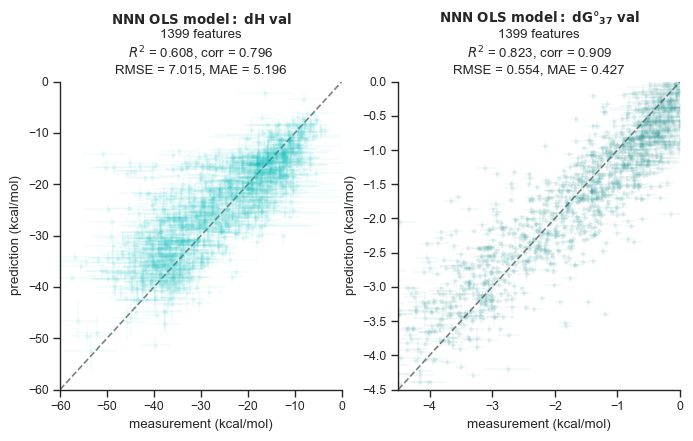

In [698]:
%%time
# with one single nupack-style hairpin mismatch parameter (.+.)
# no closing loop base pair param (as it's linearly dependent on the hairpin mismatch parameter)

feats = mf.get_feature_count_matrix(arr_1M, feature_method='get_feature_list', 
                                    fit_intercept=False, symmetry=False, sep_base_stack=True, hairpin_mm=True, ignore_base_stack=True)
print(feats.shape)

lr_dict = dict(dH=None, dG=None)
fig, ax = plt.subplots(1, 2, figsize=(8,4))
lr_dict['dH'] = mf.fit_param(arr_1M, data_split_dict, param='dH', feats=feats, ax=ax[0])
lr_dict['dG'] = mf.fit_param(arr_1M, data_split_dict, param='dG_37', feats=feats, ax=ax[1])

### Save parameters to json

In [699]:
template_file = './models/dna04.json'
out_file = './models/dna-nnn-hairpin.json'
mupack.lr_dict_2_nupack_json(lr_dict, template_file=param_set_template_file, out_file=out_file, 
                             lr_step='hairpin', adjust_triloop_terminal_penalty=True,
                             extract_hairpin_mismatch=True)

### Validation

In [709]:
hairpinloop_ind = [x for x in val_ind if (x.startswith('TRI') or x.startswith('TET'))]

In [724]:
%%time
pred = list(arr.loc[hairpinloop_ind,:].apply(lambda row: util.get_nupack_dH_dS_Tm_dG_37(row.RefSeq, row.TargetStruct, sodium=0.088, return_dict=False, param_set='./models/dna-nnn-hairpin.json'), axis=1))

arr[['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = np.nan
arr.loc[hairpinloop_ind, ['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = pred

cols = ['Tm_adj','dH_adj','dG_37_adj']
arr[cols] = arr_adj[['Tm','dH','dG_37']]

CPU times: user 5.09 s, sys: 59.4 ms, total: 5.15 s
Wall time: 5.17 s


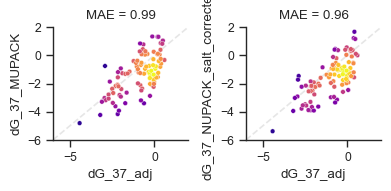

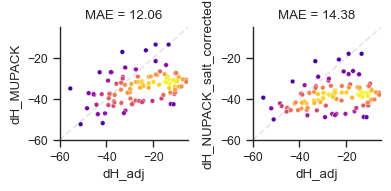

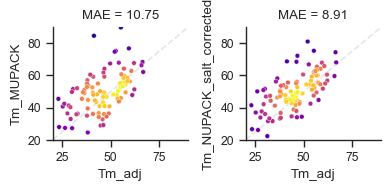

In [725]:
# Compare on array validation data
mupack.plot_mupack_nupack(arr.loc[hairpinloop_ind], '_adj', 'dG_37', [-6, 2])
mupack.plot_mupack_nupack(arr.loc[hairpinloop_ind], '_adj', 'dH', [-60, -5])
mupack.plot_mupack_nupack(arr.loc[hairpinloop_ind], '_adj', 'Tm', [20, 90])
# util.save_multi_image('./fig/models/MUPACK/model_pred_vs_array_val_v1.pdf')

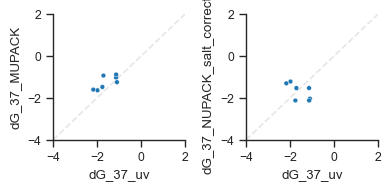

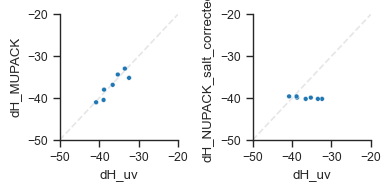

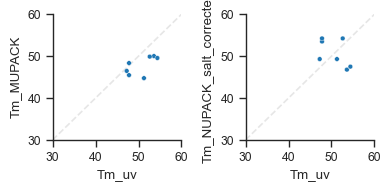

In [240]:
# compare on UV melting data
cols = ['dG_37_uv', 'Tm_uv', 'dH_uv']
uv = uv_df.query('Na_mM == 25 & is_hairpin')[cols].groupby('SEQID').apply(np.mean)

""" Switch between triloop/ tetraloop/ combination of both here """
seqid_start = 'TRI'
# hairpinloop_ind = [x for x in uv.index if ((x.startswith('TRI') or x.startswith('TET')) and x in arr.index)]
hairpinloop_ind = [x for x in uv.index if ((x.startswith(seqid_start)) and x in arr.index)]
""" END """

arr[cols] = np.nan
arr.loc[hairpinloop_ind, cols] = uv.loc[hairpinloop_ind, cols]

pred = list(arr.loc[hairpinloop_ind,:].apply(lambda row: util.get_nupack_dH_dS_Tm_dG_37(row.RefSeq, row.TargetStruct, sodium=0.088, return_dict=False, param_set='./models/dna-nnn.json'), axis=1))

arr[['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = np.nan
arr.loc[hairpinloop_ind, ['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = pred

cols = ['Tm_adj','dH_adj','dG_37_adj']
arr[cols] = arr_adj[['Tm','dH','dG_37']]

plot_mupack_nupack(arr.loc[hairpinloop_ind], '_uv', 'dG_37', [-4, 2], color_by_density=False)
plot_mupack_nupack(arr.loc[hairpinloop_ind], '_uv', 'dH', [-50, -20], color_by_density=False)
plot_mupack_nupack(arr.loc[hairpinloop_ind], '_uv', 'Tm', [30, 60], color_by_density=False)
util.save_multi_image('./fig/models/MUPACK/model_pred_vs_uv_%s_v1.pdf' % seqid_start)

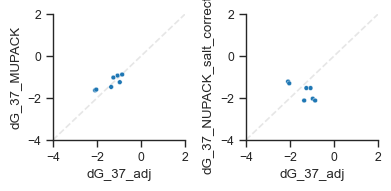

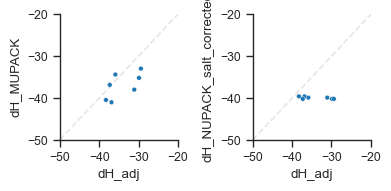

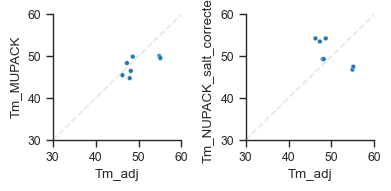

In [241]:
plot_mupack_nupack(arr.loc[hairpinloop_ind], '_adj', 'dG_37', [-4, 2], color_by_density=False)
plot_mupack_nupack(arr.loc[hairpinloop_ind], '_adj', 'dH', [-50, -20], color_by_density=False)
plot_mupack_nupack(arr.loc[hairpinloop_ind], '_adj', 'Tm', [30, 60], color_by_density=False)
util.save_multi_image('./fig/models/MUPACK/model_pred_vs_arr_val_uv_seqs_%s_v1.pdf' % seqid_start)

Triloop model works better than the tetraloop model.

## Full model with triloop & tetraloop seq params fixed

### Train

In [700]:
%%time
feats = mf.get_feature_count_matrix(arr_1M, feature_method='get_nupack_feature_list', 
                                    feature_style='nupack', fit_intercept=False)
print(feats.shape)

(27732, 1360)
CPU times: user 13.2 s, sys: 144 ms, total: 13.4 s
Wall time: 13.6 s


Get the fitted hairpinloop parameters from previous models and add the params to be fixed from original dna04 file:

In [718]:
param_set_template_file = './models/dna-nnn-hairpin.json'
fixed_pclass = ['hairpin_size', 'interior_size', 'hairpin_mismatch', 'hairpin_triloop', 'hairpin_tetraloop', 'terminal_penalty', 'stack']
fixed_coef_df, fixed_feature_names = mupack.get_fixed_params(param_set_template_file=param_set_template_file, fixed_pclass=fixed_pclass)

CPU times: user 9.71 s, sys: 17 s, total: 26.7 s
Wall time: 26.7 s


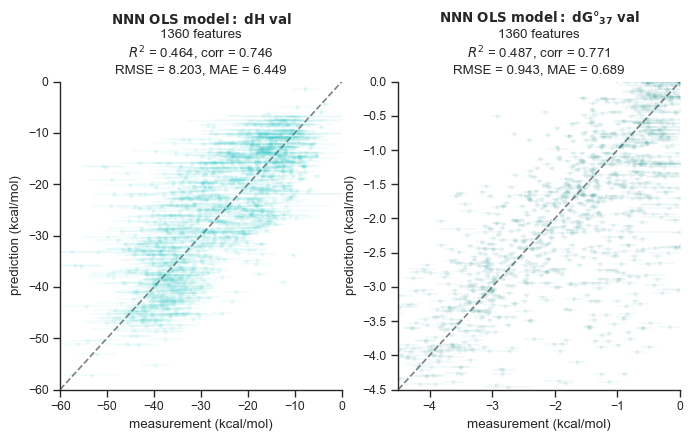

In [719]:
%%time 
fig, ax = plt.subplots(1, 2, figsize=(8,4))

lr_dict = defaultdict()

for i,param in enumerate(param_name_dict):
    lr_dict[param] = mf.fit_param(arr_1M, data_split_dict, param=param_name_dict[param], feats=feats, ax=ax[i],
                     fix_some_coef=True, fixed_feature_names=fixed_feature_names, coef_df=fixed_coef_df[[param]])

### Save parameters to json

In [720]:
param_set_template_file = './models/dna-nnn-hairpin.json'
param_set_file = './models/dna-nnn-full.json'

mupack.lr_dict_2_nupack_json(lr_dict, param_set_template_file, param_set_file, lr_step='full', 
                             comment='Fix stack parameters')

### Validation

In [721]:
hairpinloop_ind = [x for x in val_ind if (x.startswith('WC'))]# or x.startswith('TET'))]
hairpinloop_ind = np.random.choice(val_ind, 100, replace=False)
len(hairpinloop_ind)

100

In [722]:
%%time
pred = list(arr.loc[hairpinloop_ind,:].apply(lambda row: util.get_nupack_dH_dS_Tm_dG_37(row.RefSeq, row.TargetStruct, sodium=0.088, return_dict=False, param_set='./models/dna-nnn-full.json'), axis=1))

arr[['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = np.nan
arr.loc[hairpinloop_ind, ['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = pred

cols = ['Tm_adj','dH_adj','dG_37_adj']
arr[cols] = arr_adj[['Tm','dH','dG_37']]

CPU times: user 5.7 s, sys: 97.1 ms, total: 5.8 s
Wall time: 5.85 s


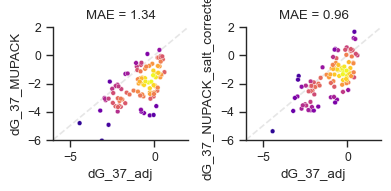

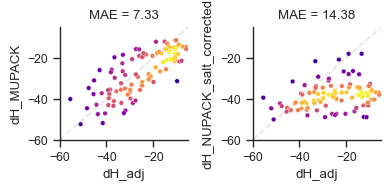

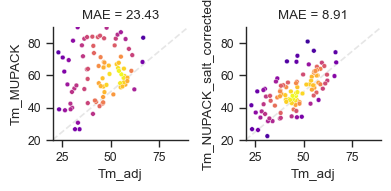

In [723]:
# Compare on array validation data
mupack.plot_mupack_nupack(arr.loc[hairpinloop_ind], '_adj', 'dG_37', [-6,2])
mupack.plot_mupack_nupack(arr.loc[hairpinloop_ind], '_adj', 'dH', [-60, -5])
mupack.plot_mupack_nupack(arr.loc[hairpinloop_ind], '_adj', 'Tm', [20, 90])
# util.save_multi_image('./fig/models/MUPACK/full/model_pred_vs_array_val_v0.pdf')

In [566]:
# compare on UV melting data
cols = ['dG_37_uv', 'Tm_uv', 'dH_uv']
uv = uv_df.query('Na_mM == 25 & is_hairpin')[cols].groupby('SEQID').apply(np.mean)

""" Switch between triloop/ tetraloop/ combination of both here """
seqid_start = ''
# hairpinloop_ind = [x for x in uv.index if ((x.startswith('TRI') or x.startswith('TET')) and x in arr.index)]
# hairpinloop_ind = [x for x in uv.index if ((x.startswith(seqid_start)) and x in arr.index)]
hairpinloop_ind = [x for x in uv.index if ((x.startswith(seqid_start)))]
""" END """

arr[cols] = np.nan
arr.loc[hairpinloop_ind, cols] = uv.loc[hairpinloop_ind, cols]

pred = list(arr.loc[hairpinloop_ind,:].apply(lambda row: util.get_nupack_dH_dS_Tm_dG_37(row.RefSeq, row.TargetStruct, sodium=0.088, return_dict=False, param_set='./models/dna-nnn.json'), axis=1))

arr[['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = np.nan
arr.loc[hairpinloop_ind, ['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = pred

cols = ['Tm_adj','dH_adj','dG_37_adj']
arr[cols] = arr_adj[['Tm','dH','dG_37']]

plot_mupack_nupack(arr.loc[hairpinloop_ind], '_uv', 'dG_37', [-5, 2], color_by_density=False)
plot_mupack_nupack(arr.loc[hairpinloop_ind], '_uv', 'dH', [-50, -20], color_by_density=False)
plot_mupack_nupack(arr.loc[hairpinloop_ind], '_uv', 'Tm', [30, 70], color_by_density=False)
util.save_multi_image('./fig/models/MUPACK/model_pred_vs_uv_%s_v1.pdf' % seqid_start)

KeyError: "['MMTM177'] not in index"

In [546]:
oligos = pd.read_csv('./data/uv_melt/ECLTables/ECLOligos230502.csv', index_col=0)

In [561]:
# compare on UV melting data
cols = ['dG_37_uv', 'Tm_uv', 'dH_uv']
uv = uv_df.query('Na_mM == 25 & is_hairpin')[cols].groupby('SEQID').apply(np.mean)

uv = uv.join(oligos[['sequence']])
uv['TargetStruct'] = '('*6 + '....' + ')'*6
""" Switch between triloop/ tetraloop/ combination of both here """
seqid_start = 'WC'
hairpinloop_ind = [x for x in uv.index if ((x.startswith(seqid_start)))]
""" END """

pred = list(uv.loc[hairpinloop_ind,:].apply(lambda row: util.get_nupack_dH_dS_Tm_dG_37(row.sequence, row.TargetStruct, sodium=0.088, return_dict=False, param_set='./models/dna-nnn.json'), axis=1))

uv[['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = np.nan
uv.loc[hairpinloop_ind, ['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = pred

pred = list(uv.loc[hairpinloop_ind,:].apply(lambda row: util.get_nupack_dH_dS_Tm_dG_37(row.sequence, row.TargetStruct, sodium=0.088, return_dict=False, param_set='./models/dna04.json'), axis=1))
cols = [x+'_NUPACK_salt_corrected' for x in ['dH', 'dS', 'Tm', 'dG_37']]
uv[cols] = np.nan
uv.loc[hairpinloop_ind, cols] = pred

plot_mupack_nupack(uv.loc[hairpinloop_ind], '_uv', 'dG_37', [-6, 2], color_by_density=False)
plot_mupack_nupack(uv.loc[hairpinloop_ind], '_uv', 'dH', [-60, -20], color_by_density=False)
plot_mupack_nupack(uv.loc[hairpinloop_ind], '_uv', 'Tm', [30, 70], color_by_density=False)
# util.save_multi_image('./fig/models/MUPACK/model_pred_vs_uv_%s_v1.pdf' % seqid_start)

ConversionError: ["could not convert to rvalue reference (#0, <class 'float'> → boost::container::small_vector<nupack::Strand, 4ul, void, void>)", "could not convert to rvalue reference (#0, <class 'float'> → boost::container::small_vector<nupack::Strand, 4ul, void, void>)"]

TODO:
- [ ] Wrap validation in a function
- [ ] Plot performance on HP UV melting dataset